# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [1]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics, svm
import matplotlib.pyplot as plt

In [139]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) -> np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert (
            learning_rate < 1
        ), f"Given learning_rate={learning_rate} is larger than 1"
        assert (
            learning_rate > 0
        ), f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate


class FullyConnected(Layer):
    def __init__(self, input_size: int, output_size: int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.weights = np.random.randn(input_size, output_size)
        self.bias = np.random.randn(output_size)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        self.y = self.x @ self.weights + self.bias
        return self.y

    def backward(self, output_error_derivative) -> np.ndarray:
        print("FullyConnected layer backward")
        print(f"output_error_derivative shape: {output_error_derivative.shape}")
        print(f"self.weights shape: {self.weights.shape}")
        print(f"self.x shape: {self.x.shape}")
        print(f"self.y shape: {self.y.shape}")
        dx = output_error_derivative.T @ self.weights.T
        print(f"dx shape: {dx.shape}")
        return dx.T


class Sigmoid(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        self.y = 1 / (1 + np.exp(-(self.x)))
        return self.y

    def backward(self, output_error_derivative) -> np.ndarray:
        print("Sigmoid layer backward")
        print(f"output_error_derivative shape: {output_error_derivative.shape}")
        print(f"self.x shape: {self.x.shape}")
        print(f"self.y shape: {self.y.shape}")
        local_grad = np.multiply((1 - self.x), self.x)
        print(f"local_grad shape: {local_grad.shape}")
        dx = output_error_derivative.T * local_grad
        print(f"dx shape: {dx.shape}")
        return dx.T


class Loss:
    def __init__(
        self, loss_function: callable, loss_function_derivative: callable
    ) -> None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x: np.ndarray) -> np.ndarray:
        """Loss function for a particular x"""
        return self.loss_function(x)

    def loss_derivative(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, y)


class Network:
    def __init__(self, layers: List[Layer], learning_rate: float) -> None:
        self.layers = layers
        self.learning_rate = learning_rate

    def compile(self, loss: Loss) -> None:
        """Define the loss function and loss function derivative"""
        self.loss = loss

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        i = 0
        for layer in self.layers:
            x = layer.forward(x)
            print(f"Layer {i} output shape: {x.shape}")
            i += 1
        return x

    def fit(
        self,
        x_train: np.ndarray,
        y_train: np.ndarray,
        epochs: int,
        learning_rate: float,
        verbose: int = 0,
    ) -> None:
        """Fit the network to the training data"""

        for epoch in range(epochs):
            print(f"Epoch {epoch}")
            for data in zip(x_train, y_train):
                x, y = data
                y = self.vectorized_result(y)
                print(f"y: {y}")
                x = np.array([x])
                output = self(x)
                current_error = output.T - y
                print(f"Current error: {current_error}")
                loss_value = self.loss.loss(current_error)
                if loss_value < 0.01:
                    print("Break")
                    print(f"Loss: {loss_value}")
                    break
                print(f"Loss: {loss_value}")
                layers_reversed = self.layers[::-1]
                loss_derivative_value = self.loss.loss_derivative(current_error, 0)
                for layer in layers_reversed:
                    loss_derivative_value = layer.backward(loss_derivative_value)
                    if isinstance(layer, FullyConnected):
                        # print(f"Loss derivative value shape: {loss_derivative_value.shape}")
                        # print(f"weights shape: {layer.weights.shape}")
                        # print(f"learning_rate: {learning_rate}")
                        layer.weights -= learning_rate * loss_derivative_value

    def vectorized_result(self, j):
        """Return a 10-dimensional unit vector with a 1.0 in the j'th position
        and zeroes elsewhere.  This is used to convert a digit (0...9)
        into a corresponding desired output from the neural network.

        """
        e = np.zeros((10, 1))
        e[j] = 1.0
        return e

# Eksperymenty

# Wnioski

In [129]:
ar1 = np.array([[1, 2, 3, 4, 1]])
print(ar1.shape)
ar2 = np.array([[2, 2, 2, 2, 2], [3, 3, 3, 3, 3], [4, 4, 4, 4, 4]])
ar2 = ar2.transpose()
print(ar2.shape)
ar3 = ar1 @ ar2
print(ar3.shape)

ar1 = np.random.randn(1, 65)
ar2 = np.random.randn(65, 6)
print(ar1.shape)
print(ar2.shape)

ar3 = ar1 @ ar2
print(ar3.shape)


nx = 10
n = 4
input_layer = FullyConnected(nx, n)
sigmoid_layer = Sigmoid()
hidden_layer = FullyConnected(n, n)
sigmoid_layer2 = Sigmoid()
out_layer = FullyConnected(n, 1)

print(hidden_layer.weights.shape)
print(hidden_layer.weights.transpose().shape)


x = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
y = input_layer.forward(x)
y = sigmoid_layer.forward(y)
y = hidden_layer.forward(y)
y = sigmoid_layer2.forward(y)
y = out_layer.forward(y)
# print(hidden_layer.x.shape)
# print(y)


dx = out_layer.backward(np.array([[1]]))
print(dx)
dx = sigmoid_layer2.backward(dx)
dx = hidden_layer.backward(dx)
dx = sigmoid_layer.backward(dx)
dx = input_layer.backward(dx)
print(dx)

(1, 5)
(5, 3)
(1, 3)
(1, 65)
(65, 6)
(1, 6)
(4, 4)
(4, 4)
FullyConnected layer backward
output_error_derivative shape: (1, 1)
self.weights shape: (4, 1)
self.x shape: (1, 4)
self.y shape: (1, 1)
dx shape: (1, 4)
[[ 0.87044479  1.3228923  -2.11688101  1.89808048]]
Sigmoid layer backward
output_error_derivative shape: (1, 4)
self.x shape: (1, 4)
self.y shape: (1, 4)
local_grad shape: (1, 4)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 4)

Data: [[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
Data shape: (1797, 64)
X train: [[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  2. ... 14.  0.  0.]
 [ 0.  1. 12. ...  0.  0.  0.]
 [ 0.  0.  0. ...  3.  0.  0.]]
X train shape: (898, 64)
Epoch 0
y: [[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Layer 0 output shape: (1, 2)
Layer 1 output shape: (1, 2)
Layer 2 output shape: (1, 2)
Layer 3 output shape: (1, 2)
Layer 4 output shape: (1, 10)
Current error: [[-0.96324985]
 [ 0.22833881]
 [ 0.44170968]
 [-0.54363284]
 [-0.47308932]
 [ 0.54758993]
 [-0.50728902]
 [ 0.85806864]
 [ 0.9849825 ]
 [ 0.25544776]]
Loss: 0.6870358842002127
FullyConnected layer backward
output_error_derivative shape: (10, 1)
self.weights shape: (2, 10)
self.x shape: (1, 2)
self.y shape: (1, 10)
dx s

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

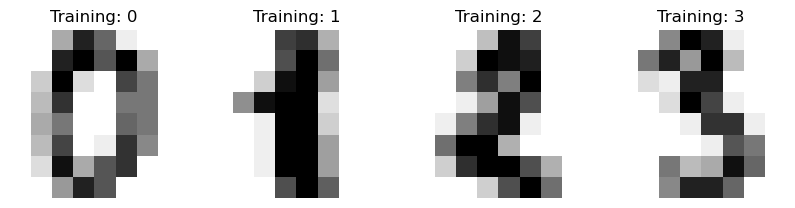

In [140]:
nx = 64
n = 2

epoch_size = 10
digits = datasets.load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
print(f"Data: {data}")
print(f"Data shape: {data.shape}")

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

print(f"X train: {X_train}")
print(f"X train shape: {X_train.shape}")


inner_layer = FullyConnected(nx, n)
sigmoid_layer_1 = Sigmoid()
hidden_layer = FullyConnected(n, n)
sigmoid_layer_2 = Sigmoid()
out_layer = FullyConnected(n, 10)


layers = [inner_layer, sigmoid_layer_1, hidden_layer, sigmoid_layer_2, out_layer]
loss_function = lambda e: np.sum(e) ** 2
loss_function_derivative = lambda e, weight: 2 * e

loss = Loss(loss_function, loss_function_derivative)
network = Network(layers, 0.01)
network.compile(loss)

network.fit(X_train, y_train, 1, 0.01)

In [36]:
a = np.array([3])
b = np.array([[4], [5], [6]])
b @ a

array([12, 15, 18])